In the previous checkpoint, we saw how examining individual variables reveals useful insights. But there is more to come! 

In data science, many of the interesting insights are discovered when we analyze variables together. For example, the comovement of the 2 variables over time reflects a common factor may affect these 2 variables, or 1 may affect the other. Or, say we have data about a disease and a hospital's records. If the average age of people with respect to their likelihood of suffering from this disease differs significantly, then this might be a very important revelation as it implies age may play an important role for the prevention or treatment of this disease.

The analysis that incorporates 2 or more variables is called **multivariate analysis**, and in this checkpoint, we discuss several multivariate techniques. The figure below shows where we are in the EDA process:

![data_exploration.png](assets/data_exploration.png)


So far in this module, we've used the YouTube dataset from the Kaggle in our examples. In this checkpoint, we will give some examples from another dataset which is also from Kaggle, called ["Students Performance in Exams"](https://www.kaggle.com/spscientist/students-performance-in-exams/home). This dataset consists of information about some student backgrounds along with their exam results in math, reading, and writing.
    
We'll first examine pairwise relationships in our data. Technically, this is called **bivariate analysis** when we analyze only two variables together. But this is just a special case of multivariate analysis. Think about the combinations of possible matchings in bivariate analysis with respect to the variable types. Since we have 2 types of variables that are categorical and continuous, we have in total of 3 possible matchings (where order is unimportant): **continuous-continuous**, **continuous-categorical**, **categorical-categorical**. Each combination requires different analysis, so we individually discuss them.

# Bivariate analysis of two continuous variables

## Scatterplot

One of the most informative ways of looking at the relationship between 2 continuous variables is to draw a scatterplot (also known as  a scattergram). For example, if we see the 1st variable's value usually goes up when the 2nd one goes up, then this indicates a positive relationship.

Let's look at this using YouTube dataset:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'youtube'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

youtube_df = pd.read_sql_query('select * from youtube',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

# we're dealing with the missing values

youtube_df["Video Uploads"] = youtube_df["Video Uploads"].apply(str.strip).replace("--", np.nan)
youtube_df["Video Uploads"] = pd.to_numeric(youtube_df["Video Uploads"], downcast="float")

youtube_df["Subscribers"] = youtube_df["Subscribers"].apply(str.strip).replace("--", np.nan)
youtube_df["Subscribers"] = pd.to_numeric(youtube_df["Subscribers"], downcast="float")

youtube_df.Grade = youtube_df.Grade.apply(str.strip).replace("", np.nan)


youtube_df["Video Uploads"].fillna(youtube_df["Video Uploads"].mean(), inplace=True)
youtube_df["Subscribers"].fillna(youtube_df["Subscribers"].mean(), inplace=True)


# We apply one-way winsorization to the highest end
# of the value distribution. As we have a lot of extreme
# values, we set the values of the outliers to the 
# value of the 90th percentile. 
youtube_df["winsorized_uploads"] = winsorized_views = winsorize(youtube_df["Video Uploads"], (0, 0.10))
youtube_df["winsorized_subscribers"] = winsorized_views = winsorize(youtube_df["Subscribers"], (0, 0.10))
youtube_df["winsorized_views"] = winsorized_views = winsorize(youtube_df["Video views"], (0, 0.10))

for i in range(0, len(youtube_df.Grade)):
    if pd.isnull(youtube_df.Grade[i]):
        youtube_df.Grade[i] = youtube_df.Grade[i-1]
        
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.scatter(youtube_df["Video views"], youtube_df["Video Uploads"])
plt.title("video views vs video uploads")

plt.subplot(1,3,2)
plt.scatter(youtube_df["Video views"], youtube_df["Subscribers"])
plt.title("video views vs subscribers")

plt.subplot(1,3,3)
plt.scatter(youtube_df["Video Uploads"], youtube_df["Subscribers"])
plt.title("video uploads vs subscribers")

plt.show()

<Figure size 1800x500 with 3 Axes>

In the second scatterplot, we see a positive relationship between the video views and the number of subscribers. Now, let's look at the relationship between different pairs of student test scores:

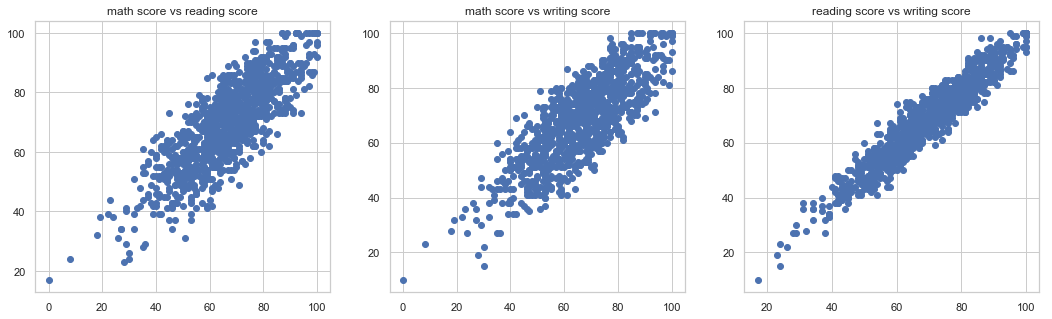

In [2]:
postgres_db = 'studentsperformance'

engine2 = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

student_df = pd.read_sql_query('select * from studentsperformance',con=engine2)

# no need for an open connection, 
# as we're only doing a single query
engine2.dispose()

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.scatter(student_df["math score"], student_df["reading score"])
plt.title("math score vs reading score")

plt.subplot(1,3,2)
plt.scatter(student_df["math score"], student_df["writing score"])
plt.title("math score vs writing score")

plt.subplot(1,3,3)
plt.scatter(student_df["reading score"], student_df["writing score"])
plt.title("reading score vs writing score")

plt.show()

Oops! Success appears to be not due to chance, but rather hard work. We see there are positive relationships between all the score types.

**<font color=red>A note on outliers</font>: Recall our checkpoint on outliers, we separately looked at extreme values for each variable. There is also another type of outlier, called a *two-dimensional outlier*, that represents unusual *combinations* of values. If you look at the scatterplots above carefully, you may notice some of those unusual value pairs. To deal with these, you can apply one of the techniques we explained in the outliers checkpoint.**

## Correlation coefficient

Another informative statistic that measures the comovements of two continuous variables is **correlation coefficient**. The correlation coefficient (*r*) is a numeric representation of the linear relationship between 2 continuous variables. Correlations range from -1 (a perfect negative relationship: as values in 1 variable go up, values in the other go down) to 0 (no relationship between the variables) to 1 (a perfect positive relationship: as values in 1 variable go up, values in the other go up as well).
 
Notice what we observed in the scatterplots is actually a visual representation of the correlations between variables. Using a number that is indexed between -1 and 1 adds a layer of precision and ease of interpretation across items.

Pandas provides us with the `.corr()` function to derive the correlation coefficients across all continuous features in a data frame. Let's apply this function to both the YouTube and student performance datasets:

In [3]:
# get correlation matrix
youtube_df.corr()

,Video Uploads,Subscribers,Video views,winsorized_uploads,winsorized_subscribers,winsorized_views
Video Uploads,1.000000,0.011329,0.092423,0.473634,0.012593,0.134971
Subscribers,0.011329,1.000000,0.784449,0.082880,0.778046,0.626605
Video views,0.092423,0.784449,1.000000,0.219291,0.578920,0.700070
winsorized_uploads,0.473634,0.082880,0.219291,1.000000,0.097699,0.307744
winsorized_subscribers,0.012593,0.778046,0.578920,0.097699,1.000000,0.743256
winsorized_views,0.134971,0.626605,0.700070,0.307744,0.743256,1.000000


In [4]:
# get correlation matrix
student_df.corr()

,math score,reading score,writing score
math score,1.000000,0.817580,0.802642
reading score,0.817580,1.000000,0.954598
writing score,0.802642,0.954598,1.000000


Here we can see the correlation between video views and subscribers is around 0.78, and that the correlation between the reading and writing scores is higher than any other combination.

Another convenient way to look at the correlations is to render the matrix as a heatmap. This combines the effectiveness of visualizations and the precision of statistics. Such a technique is especially useful if we have a lot of variables in the dataset. Lighter colors indicate a higher correlation between variables. Let's draw correlation matrices for both of our datasets as heatmaps using Seaborn:

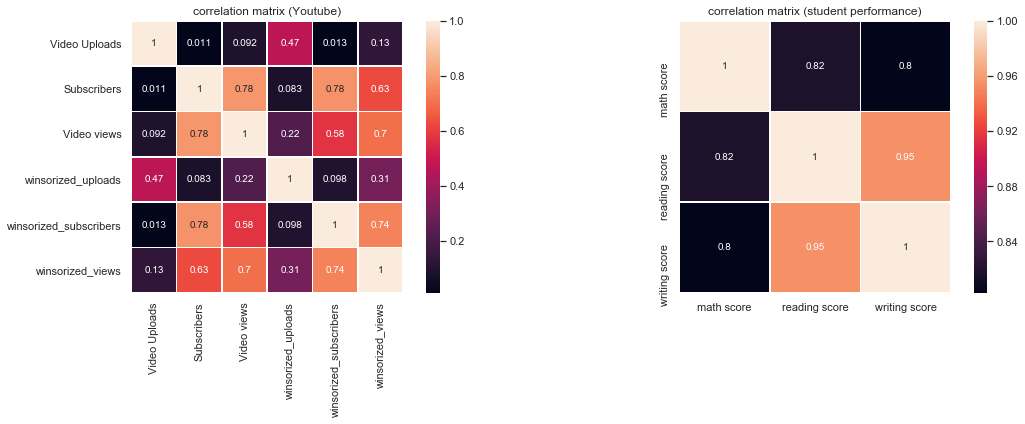

In [5]:
# make the correlation matrices.
corrmat_youtube = youtube_df.corr()

corrmat_student = student_df.corr()

# heatmaps are a great way to get 
# a quick visual read on a big correlation matrix.

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
# draw the heatmap using seaborn.
sns.heatmap(corrmat_youtube, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Youtube)")

plt.subplot(1,2,2)
# draw the heatmap using seaborn.
sns.heatmap(corrmat_student, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (student performance)")

plt.show()

# try to match the correlation numbers 
# to the scatterplots above to get a 
# sense of what each magnitude of 
# correlation can look like.



# Bivariate analysis of  a continuous-categorical pair

When we analyze a continuous and a categorical variable pair, we usually look at some metric of the continuous variable for each value of the categorical variable. If we observe different values across categories, then this implies the categorical variable has some important information regarding the continuous variable.

One way to look at this is to use the Pandas `.groupby()` function where we use the categorical variable as the grouping variable. After calling this function, we can call some aggregation function like `.mean()` or `.count()` to derive metrics for the continuous variable by group. Let's do this in the YouTube dataset using the *Grade* variable as the categorical variable:

In [6]:
# derive averages by group
youtube_df.groupby("Grade").mean()

,Video Uploads,Subscribers,Video views,winsorized_uploads,winsorized_subscribers,winsorized_views
Grade,,,,,,
A,5353.923340,4.931877e+06,2.356715e+09,1675.311890,3398754.250,1.447002e+09
A+,16547.927734,1.150483e+07,6.053121e+09,2729.877930,5061679.000,2.088445e+09
A++,37450.699219,2.228176e+07,2.119909e+10,4673.700195,5590006.000,2.468241e+09
A-,4136.514648,2.784051e+06,1.041149e+09,1319.476562,2329109.250,8.810693e+08
B+,2987.168457,1.620059e+06,5.259158e+08,1120.130737,1513428.625,5.085668e+08


As we can see, there are substantial differences in the means of the variables across grade groups. Instead of looking at a single metric like `mean`, we could also call the `.describe()` function after `.groupby()`. Although useful, it can be tedious to analyze the resulting table for datasets containing many continuous variables. 

Visualization can also help us analyze continuous and categorical variable pairs. We can use box, bar, or other plots to visualize the differences of the continuous variable across the groups of the categorical variable.

Let's begin with bar plots:

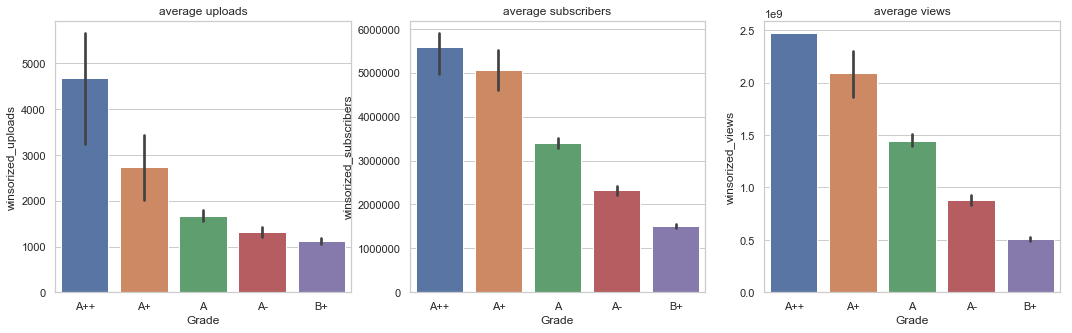

In [7]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
# draw the heatmap using seaborn.
sns.barplot(youtube_df["Grade"], youtube_df["winsorized_uploads"])
plt.title("average uploads")

plt.subplot(1,3,2)
# draw the heatmap using seaborn.
sns.barplot(youtube_df["Grade"], youtube_df["winsorized_subscribers"])
plt.title("average subscribers")

plt.subplot(1,3,3)
# draw the heatmap using seaborn.
sns.barplot(youtube_df["Grade"], youtube_df["winsorized_views"])
plt.title("average views")

plt.show()

As we can see, averages decrease as the grade lowers. **However, visualizing differences is not a formal way of stating that there are significant differences across categories!** For this, we need to use a proper statistical test, such as a t-test or ANOVA. So, let's use the t-test to learn whether the differences are statistically significant:

In [8]:
# Test whether group differences are significant.
grades = youtube_df["Grade"].unique()
grouped_df = youtube_df.groupby("Grade")
for var in ["winsorized_uploads", "winsorized_subscribers", "winsorized_views"]:
    print("------------------------------------------------")
    print("Comparisons for variable: {}".format(var))
    print("------------------------------------------------")
    for i in range(0, len(grades)):
        for j in range(i+1, len(grades)):
            print("t-test between groups {0} and {1}:".format(grades[i], grades[j]))
            print(stats.ttest_ind(
                youtube_df[youtube_df["Grade"]==grades[i]][var], 
                youtube_df[youtube_df["Grade"]==grades[j]][var]
            ))

------------------------------------------------
Comparisons for variable: winsorized_uploads
------------------------------------------------
t-test between groups A++ and A+:
Ttest_indResult(statistic=2.3701079407396466, pvalue=0.021763510628877547)
t-test between groups A++ and A:
Ttest_indResult(statistic=4.635430718045579, pvalue=4.046909833444881e-06)
t-test between groups A++ and A-:
Ttest_indResult(statistic=5.849570829755956, pvalue=6.610430711945347e-09)
t-test between groups A++ and B+:
Ttest_indResult(statistic=6.89526380025047, pvalue=6.542417415099145e-12)
t-test between groups A+ and A:
Ttest_indResult(statistic=3.226986439748338, pvalue=0.0012914862720250933)
t-test between groups A+ and A-:
Ttest_indResult(statistic=4.847071421048167, pvalue=1.4393742004398387e-06)
t-test between groups A+ and B+:
Ttest_indResult(statistic=6.250454131708066, pvalue=4.672651556636408e-10)
t-test between groups A and A-:
Ttest_indResult(statistic=4.134406977202173, pvalue=3.7067376468950

Some differences are statistically significant and some are not.

# Bivariate analysis of  two categorical variables

The last combination remaining is the pair of two categorical variables. Since categorical variables take a limited number of different values by definition, the most common technique used is the observation count of all value pairs. The Pandas `.crosstab()` function does this for us. Let's use it on the students performance dataset:

In [9]:
# print first few observations
student_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [10]:
# create crosstab: gender by race/ethnicity
count_table = pd.crosstab(student_df["gender"], student_df["race/ethnicity"])
count_table

race/ethnicity,group A,group B,group C,group D,group E
gender,,,,,
female,36,104,180,129,69
male,53,86,139,133,71


As we have seen, a visualization can help emphasize the differences. A bar plot with the height of each bar indicating the number of datapoints in each combination of variables conveys the crosstab's information:

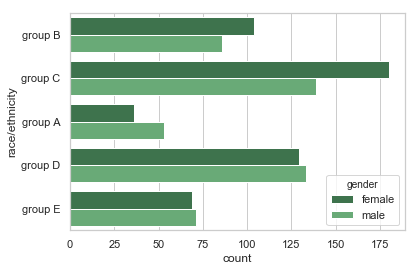

In [11]:
# Plot counts for each combination of levels.
sns.countplot(y="race/ethnicity", hue="gender", data=student_df, palette="Greens_d")
plt.show()

As a reminder, don't forget the differences we see above should be checked using formal statistical tests. For this purpose, we can use the Chi-squared test. It indicates whether one combination of variables is significantly different than the rest:

In [12]:
# Test will return a chi-square test statistic and a p-value. Like the t-test,
# the chi-square is compared against a distribution (the chi-square
# distribution) to determine whether the group size differences are large
# enough to reflect differences in the population.
print(stats.chisquare(count_table, axis=None))

Power_divergenceResult(statistic=181.70000000000002, pvalue=2.237210012745866e-34)


It seems the differences are statistically significant.

**<font color=red>A note on small groups</font>: Similar to how unusual two-dimensional datapoints could skew our analysis, groups with very small variances relative to other groups and groups with a very small number of observations can also mislead us. Hence, we should keep in mind interpreting the differences for small groups should be done cautiously.**

# Putting the target at the center

Throughout this checkpoint, we have kept the discussion general and we didn't focus on a single variable. However, in a real life data science project we will put special emphasis on a single variable. This single most important variable is the one we try to understand and explain. This variable is called the **target** or **outcome** variable.

Consider the YouTube dataset. Let's say our goal is to predict the video views for a channel, as this will lead us to guess how much money a channel makes from YouTube. In this case, our target variable becomes the *Video views*. We want to understand whether the other variables in our dataset have some information to help us predict the number of views. In this example, our target variable is continuous and in our bivariate analysis, we can look at the correlation coefficients of the *Video views* with respect to other continuous variables to get a sense of how much other variables are related with our target. If our target were a categorical variable, then we would apply other techniques to explore the relationship of our target to the other variables.

**Hence, our target variable should be located at the center of our exploratory data analysis**.

That said, by no means are we claiming any multivariate analysis should include *only* the target variable. Knowing the relationships between the variables other than the target variable is also a useful insight. As we'll see in the next checkpoint, one objective of a data science project is to feed our model as few variables as possible while losing as little information as possible. Of course, this is a trade-off, and we strike the balance by detecting features that are least useful in the presence of the other features. 

**<font color=red>A note on the number of targets</font>: Although in a majority of the data science projects we only have a single target, in some cases having multiple targets is also possible. Here, we simply make a note of it without going any further as those cases are rare and usually require advanced techniques that are beyond the scope of the bootcamp.**

## Assignment

In this assignment, you keep working with the Students Performance in Exams dataset from Kaggle. You should access the data from the Thinkful database. Here's the credentials you can use to connect to the database:

postgres_user = 'dsbc_student'<br>
postgres_pw = '7\*.8G9QH21'<br>
postgres_host = '142.93.121.174'<br>
postgres_port = '5432'<br>
postgres_db = 'studentsperformance'<br>

To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

1. Are there any differences between the genders, ethnicities, and parental level of education with respect to their performances in exams?
2. Are there any differences between the lunch types with respect to their performances in exams? If there are, how do you explain this?
3. Does the test preparation course seem to have an effect on the exam performances?
4. Which 2 exam scores are most correlated with each other?

Submit your work below, and plan on discussing with your mentor. You can also take a look at these [example solutions](https://github.com/Thinkful-Ed/data-201-assignment-solutions/blob/master/model_prep_data_exploration_2/solution.ipynb).